Task - 1A: Using abt small.csv and buy small.csv, implement the linkage between the
two data sets.
Your code for this question is to be contained in a single Python le called task1a.py and
produce a single csv le task1a.csv containing the following two column headings:
idAbt,idBuy
Each row in the datale must contain a pair of matched products. For example, if your
algorithm only matched product 10102 from the Abt dataset with product
203897877 from the Buy dataset your output task1a.csv would be as follows:
idAbt, idBuy
10102,203897877

In [5]:
import pandas as pd
import re
import math
import csv
from fuzzywuzzy import fuzz 
import numpy as np

In [6]:
# Replace data
abt_small = pd.read_csv('abt_small.csv', usecols=['idABT', 'name'],
                      encoding='ISO-8859-1', dtype={
    'idABT': str,
    'name': str,
    })


buy_small = pd.read_csv('buy_small.csv', usecols=['idBuy', 'name'],
                      encoding='ISO-8859-1', dtype={
    'idBuy': str,
    'name': str,
    })

# rename columns
abt_small.rename(columns={
    'idABT': 'idAbt',
    'name': 'ABTName'}, inplace=True)
buy_small.rename(columns={
    'idBuy': 'idBuy',
    'name': 'BuyName'}, inplace=True)

abt_small['tmp'] = buy_small['tmp'] = 1

### 1a New Algorithm: match serial number first

In [7]:
def getCode(str):
    str = str.replace('-', '');
    code = re.findall(r'((?:[a-zA-Z]+[0-9]|[0-9]+[a-zA-Z])[a-zA-Z0-9]*)', str)
    return code 

In [8]:
s1 = getCode('OmniMount 3-Shelf Large-Component Tower - G303G')
s2 = getCode("OmniMount G-123 3-Shelf Large-Component Tower - G303G")
print(s1)
print(s2)
print(fuzz.token_set_ratio(s1,s2))

['3Shelf', 'G303G']
['G123', '3Shelf', 'G303G']
100


In [9]:
# Replace data
abt_small = pd.read_csv('abt_small.csv', usecols=['idABT', 'name', 'description'],
                      encoding='ISO-8859-1', dtype={
    'idABT': str,
    'name': str,
    'description': str
    })


buy_small = pd.read_csv('buy_small.csv', usecols=['idBuy', 'name'],
                      encoding='ISO-8859-1', dtype={
    'idBuy': str,
    'name': str,
    })

# rename columns
abt_small.rename(columns={
    'idABT': 'idAbt',
    'name': 'AbtName',
    'description' : 'des'}, inplace=True)
buy_small.rename(columns={
    'idBuy': 'idBuy',
    'name': 'BuyName'}, inplace=True)

# remove '/' in description
abt_small['codeAbt'] = abt_small['des'].apply(lambda x: getCode(x))
buy_small['codeBuy'] = buy_small['BuyName'].apply(lambda x: getCode(x))
# add column tmp as a key for further cross merge

abt_small['tmp'] = buy_small['tmp'] = 1

In [10]:
with open('task1a.csv', 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['idAbt','idBuy', 'code_match_ratio'])
    abt_nrows = abt_small.shape[0]
    # modified from cross merge algorithm 
    for i in range(abt_nrows):
        merge = pd.merge(abt_small.iloc[[i]], buy_small, how='outer',
                        on=['tmp']).drop(columns='tmp')
        for j in range(merge.shape[0]):
            Str1 = merge.at[j, 'des']
            Str2 = merge.at[j, 'BuyName']
            Str3 = merge.at[j, 'codeAbt']
            Str4 = merge.at[j, 'codeBuy']

            Token_Set_Ratio = fuzz.token_set_ratio(Str1.lower(),Str2.lower())
            code_match_ratio = fuzz.token_set_ratio(Str3,Str4)
            if code_match_ratio >= 80 or Token_Set_Ratio >= 70:
                writer.writerow([merge.at[j, 'idAbt'], merge.at[j, 'idBuy'], code_match_ratio])
                

In [11]:
df = pd.read_csv('task1a.csv', usecols=['idAbt', 'idBuy', 'code_match_ratio'],
                      encoding='ISO-8859-1', dtype={
    'idAbt': str,
    'ABTName':str,
    'idBuy': str,
    'BuyName':str,
    })

df = df.sort_values(["idAbt", "code_match_ratio"], ascending = (True, False))
df = df.drop_duplicates(subset='idAbt', keep="first")

df = df.sort_values(["idBuy", "code_match_ratio"], ascending = (True, False))
df = df.drop_duplicates(subset='idBuy', keep="first")

df = df.drop(axis = 1, columns='code_match_ratio')
df.to_csv('task1a.csv',index = False)


### Evaluate B1 algorithim

In [12]:
# caculate recall ratio
truth = pd.read_csv('abt_buy_truth_small.csv', encoding='ISO-8859-1')
print('length of truth')
print(truth.shape[0])
result = pd.read_csv('task1a.csv', encoding='ISO-8859-1')
print('length of result')
print(result.shape[0])
tp = pd.merge(truth, result,how='inner', left_on=['idAbt','idBuy'], right_on = ['idAbt','idBuy'])
tp.to_csv()

print('length of true positive')
print(tp.shape[0])


a = pd.read_csv('abt_small.csv', usecols=['idABT', 'description'], encoding='ISO-8859-1')
b = pd.read_csv('buy_small.csv', usecols=['idBuy', 'name'], encoding='ISO-8859-1')



print('recall ratio')
print(tp.shape[0]/truth.shape[0])
fail_recall = pd.concat([tp,truth]).drop_duplicates(keep=False)

#fail_recall.to_csv('fail_recall.csv', index = False)


print('precision ratio')
print(tp.shape[0]/result.shape[0])
fail_precise = pd.concat([tp,result]).drop_duplicates(keep=False)
#fail_precise.to_csv('fail_precise.csv', index = False)



length of truth
149
length of result
148
length of true positive
126
recall ratio
0.8456375838926175
precision ratio
0.8513513513513513


### Task - 1B: Implement a blocking method for the linkage of the abt.csv and buy.csv data
sets.
Your code is be contained in a single Python le called task1b.py and must produce two
csv les abt blocks.csv and buy blocks.csv, each containing the following two column
headings:
block_key, product_id
The product id eld corresponds to the idAbt and idBuy of the abt.csv and buy.csv les
respectively. Each row in the output les matches a product to a block. For example, if your
algorithm placed product 10102 from the Abt dataset in blocks with block keys x & y, your
abt blocks.csv would be as follows:
block_key, product_id
x,10102
y,10102

In [54]:
import pandas as pd
import re
import math
import csv
from fuzzywuzzy import fuzz 
import numpy as np

In [55]:
def allocate(allocator, product):
    ''' 
        assign blocks based on manufacturer names
    
    '''
    for i in range(len(allocator)):
        if allocator[i] == str(product):
            return i

In [56]:
def get_manu(name):
    if type(name) == str:
        return name.split()[0].lower()
    return ''

In [57]:

# read data
abt = pd.read_csv('abt.csv', usecols=['idABT', 'name'],
                      encoding='ISO-8859-1', dtype={
    'idABT': str,
    'name': str,
    })


buy = pd.read_csv('buy.csv', usecols=['idBuy', 'name', 'manufacturer'],
                      encoding='ISO-8859-1', dtype={
    'idBuy': str,
    'name': str,
    })

# rename columns
abt.rename(columns={
    'idABT': 'idAbt',
    'name': 'ABTName'}, inplace=True)
buy.rename(columns={
    'idBuy': 'idBuy',
    'name': 'BuyName',
    'manufacturer': 'manufacturer'}, inplace=True)


In [58]:
abt['manuABT'] = abt['ABTName'].apply(lambda x : get_manu(x))

buy['manuBuy'] = buy['manufacturer'].astype(str) + ' ' +  buy['BuyName'].astype(str)

buy['manuBuy'] = buy['manuBuy'].apply(lambda x : get_manu(x))

allocator = abt['manuABT'].append(buy['manuBuy'])
allocator = list(set(allocator))
print(allocator)

['canon', 'omnimount', 'plantronics', 'tree', 'lowepro', 'ihome', 'pioneer', 'polkaudio', 'sennheiser', 'fellowes', 'lacie', 'unreal', 'lg', 'cuisinart', 'monster', 'unknown', 'apple', 'nikon', 'speck', 'blueant', 'olympus', 'sdi', 'peerless', 'tech', 'simpletech', 'jawbone', 'pure', 'haier', 'applecare', 'garmin', 'danby', 'tivo', 'tom', 'logitech', 'tomtom', 'smith', 'bose', 'square', 'dbl', 'skagen', 'belkin', 'polk', 'z-line', 'at&t', 'sirius', 'contour', 'sanus', 'kensington', 'nan', 'kitchenaid', 'samsung', 'sennheisser', 'robot', 'mosquito', 'alpine', 'delonghi', 'case', 'sharp', 'vmware', 'boston', 'universal', 'hoover', 'xm', 'elgato', 'techcraft', 'nokia', 'denon', 'electrolux', 'yamaha', 'irobot', 'netgear', 'klipsch', 'waring', 'jabra', 'altec', 'whirlpool', 'transcend', 'flip', 'oregon', 'mitsubishi', 'audiovox', 'uniden', 'toshiba', 'tripp', 'nyko', 'lucasarts', 'lasonic', 'maytag', 'microsoft', 'panasonic', 'terk', 'lego', 'tomtom,', 'linksys', 'escort', 'eureka', 'brack

In [59]:
with open('abt_blocks.csv', 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['block_key', 'product_id'])
    
    for i in range(abt.shape[0]):
        block = allocate(allocator, abt.at[i, 'manuABT'])
        writer.writerow([block, abt.loc[i, 'idAbt']])

In [60]:
with open('buy_blocks.csv', 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['block_key', 'product_id'])

    for i in range(buy.shape[0]):
        block = allocate(allocator, buy.at[i, 'manuBuy'])
        writer.writerow([block, buy.loc[i, 'idBuy']])

### Now evaluate pair completeness and reduction ratio.

In [61]:
truth = pd.read_csv('abt_buy_truth.csv', encoding='ISO-8859-1')
abt = pd.read_csv('abt_blocks.csv', encoding='ISO-8859-1').rename(columns=
                                            {'product_id': 'idAbt'})
buy = pd.read_csv('buy_blocks.csv', encoding='ISO-8859-1').rename(columns=
                                            {'product_id': 'idBuy'})
pair_completeness = pd.merge(pd.merge(abt, truth), pd.merge(buy, truth),
                             how='inner').shape[0]/truth.shape[0]

n = pd.read_csv('abt.csv', encoding='ISO-8859-1').shape[0] * pd.read_csv('buy_small.csv', encoding='ISO-8859-1').shape[0]

abt_block = abt['block_key'].values.tolist()
buy_block = buy['block_key'].values.tolist()

tp_plus_fp = 0

for i in range(len(allocator)):
    tp_plus_fp += abt_block.count(i) * buy_block.count(i)

reduction_ratio = 1 - tp_plus_fp / n

In [62]:
print('Pair completeness: {0:.3f}\nReduction ratio: {1:.3f}'.format(pair_completeness, reduction_ratio))

Pair completeness: 0.953
Reduction ratio: 0.761


### Task2a

we wish to understand how the information can be used to
predict average lifespan in dierent countries. To this end, we have provided the world.csv
le, which contains some of the World Development Indicators for each country and the
life.csv le containing information about the average lifespan for each country (based on
data from the World Health Organization) [2]. Each data le also contains a country name,
country code and year as identiers for each record. These may be used to link the two
datasets but should not be considered features.

Compare the performance of the following 3 classication algorithms: k-NN (k=3
and k=7) and Decision tree (with a maximum depth of 3) on the provided data. You may use
sklearn's KNeighborsClassier and DecisionTreeClassier functions for this task.

In [93]:
import pandas as pd
import numpy as np
import csv
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

### Organise and verify your data: Before you begin you should ensure that your dataset is
sorted in ascending alphabetical order by country and that any countries not present in both
world.csv and life.csv are discarded.

In [94]:
world = pd.read_csv('world.csv', dtype={'Time': str}, encoding='ISO-8859-1')
life = pd.read_csv('life.csv', usecols=['Country Code', 'Life expectancy at birth (years)'],
                   dtype={'Year': str}, encoding='ISO-8859-1')


df = pd.merge(world, life, how='inner', on=['Country Code'])
df.columns=df.columns.str.strip()
df = df.sort_values(["Country Code"], ascending = True)
data = df[list(world.columns)[3:]]

classlabel = df['Life expectancy at birth (years)']
x_train, x_test, y_train, y_test = train_test_split(data, classlabel, train_size=0.7, test_size=0.3, random_state=200)


In [95]:
# preprocessing data
train_median = {col: x_train[col][x_train[col]!='..'].astype(float).median()
                  for col in list(x_train.columns)}
for col in train_median.keys():
    for i in range(df.shape[0]):
        if i in x_train.index and x_train.at[i, col] == '..':
            x_train.at[i, col] = train_median[col]
            
with open('task2a.csv', 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['feature', 'median', 'mean', 'variance'])
    for col in train_median.keys():
        writer.writerow([col, train_median[col], x_train[col].astype(float).mean(), x_train[col].astype(float).var()])
test_median = {col: x_test[col][x_test[col]!='..'].astype(float).median()
                  for col in list(x_test.columns)}
for col in test_median.keys():
    for i in range(df.shape[0]):
        if i in x_test.index and x_test.at[i, col] == '..':
            x_test.at[i, col] = test_median[col]
            
            

scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [96]:
# Decision tree (with a maximum depth of 3)
dt = DecisionTreeClassifier(criterion="entropy",random_state=200, max_depth=6)
dt.fit(x_train, y_train)
yd_pred=dt.predict(x_test)
print('Accuracy of decision tree: {0}'.format(np.around(accuracy_score(y_test, yd_pred), decimals=3)))

Accuracy of decision tree: 0.709


In [97]:
# fit a K-nearest neighbor classifier with K=3
knn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
knn3.fit(x_train, y_train)
y3_pred=knn3.predict(x_test)
print('Accuracy of k-nn (k=3): {0}'.format(np.around(accuracy_score(y_test, y3_pred), decimals=3)))


Accuracy of k-nn (k=3): 0.691


In [98]:
# fit a K-nearest neighbor classifier with K=7
knn7 = neighbors.KNeighborsClassifier(n_neighbors=7)
knn7.fit(x_train, y_train)
y7_pred=knn7.predict(x_test)
print('Accuracy of k-nn (k=7): {0}'.format(np.around(accuracy_score(y_test, y7_pred), decimals=3)))

Accuracy of k-nn (k=7): 0.727


### Task 2b 

In [335]:
import numpy as np
import math,random
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
import pandas as pd
import csv
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing



def VAT(R):
    """

    VAT algorithm adapted from matlab version:
    http://www.ece.mtu.edu/~thavens/code/VAT.m

    Args:
        R (n*n double): Dissimilarity data input
        R (n*D double): vector input (R is converted to sq. Euclidean distance)
    Returns:
        RV (n*n double): VAT-reordered dissimilarity data
        C (n int): Connection indexes of MST in [0,n)
        I (n int): Reordered indexes of R, the input data in [0,n)
    """
        
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I


In [336]:
world = pd.read_csv('world.csv', dtype={'Time': str}, encoding='ISO-8859-1')
life = pd.read_csv('life.csv', usecols=['Country Code', 'Life expectancy at birth (years)'],
                   dtype={'Year': str}, encoding='ISO-8859-1')


df = pd.merge(world, life, how='inner', on=['Country Code'])
df.columns=df.columns.str.strip()
df = df.sort_values(["Country Code"], ascending = True)
data = df[list(world.columns)[3:]]

classlabel = df['Life expectancy at birth (years)']
x_train, x_test, y_train, y_test = train_test_split(data, classlabel, train_size=0.7, test_size=0.3, stratify = classlabel, random_state=4)

In [337]:
# preprocessing data
train_median = {col: x_train[col][x_train[col]!='..'].astype(float).median()
                  for col in list(x_train.columns)}

for col in train_median.keys():
    for i in range(df.shape[0]):
        if i in x_train.index and x_train.at[i, col] == '..':
            x_train.at[i, col] = train_median[col]
test_median = {col: x_test[col][x_test[col]!='..'].astype(float).median()
                  for col in list(x_test.columns)}
for col in test_median.keys():
    for i in range(df.shape[0]):
        if i in x_test.index and x_test.at[i, col] == '..':
            x_test.at[i, col] = test_median[col]

### Feature Engineering and Selection(6 marks)

Interaction term pairs. Given a pair of features f1 and f2, create a new feature f12 = f1 x f2. All possible pairs can be considered.


### interaction term pairs

In [338]:
x_train_org = x_train.astype(float).copy()
x_test_org = x_test.astype(float).copy()

# interaction term pairs
ncols = x_train.shape[1]
nrows = x_train.shape[0] 
for i in range(ncols-1):
    for j in range(i+1, ncols):
        lst = x_train.iloc[:, i].astype(float) * x_train.iloc[:, j].astype(float)
        x_train[x_train.columns[i]+ '+' + x_train.columns[j]] = lst
        
ncols = x_test.shape[1]
nrows = x_test.shape[0]

for i in range(ncols-1):
    for j in range(i+1, ncols):
        lst = x_test.iloc[:, i].astype(float) * x_test.iloc[:, j].astype(float)
        x_test[x_test.columns[i]+ '+' + x_test.columns[j]] = lst


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [339]:
print('number of features in x_train before')
print(x_train_org.shape[1])
print('number of features in x_test before')
print(x_test_org.shape[1])
print('number of features in x_train after')
print(x_train.shape[1])
print('number of features in x_train after')
print(x_test.shape[1])
print('Interaction Term Pairs for Training Set (before normalisation)')
print('nrows x ncols:')
print(x_train.iloc[:, 20:].shape)
print(x_train.iloc[:, 20:])
print('Interaction Term Pairs for Test Set (before normalisation)')
print('nrows x ncols:')
print(x_test.iloc[:, 20:].shape)
print(x_test.iloc[:, 20:])

number of features in x_train before
20
number of features in x_test before
20
number of features in x_train after
210
number of features in x_train after
210
Interaction Term Pairs for Training Set (before normalisation)
nrows x ncols:
(128, 190)
     Access to electricity (% of population) [EG.ELC.ACCS.ZS]+Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD]  \
75                                        2.739860e+05                                                                                    
43                                        2.033148e+06                                                                                    
13                                        1.345303e+06                                                                                    
117                                       3.756563e+06                                                                                    
178                                       4.251103e+05   

### Clustering Labels

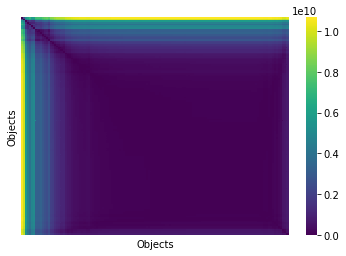

In [340]:
# generate heatmap
x_train2 = x_train.astype(float).copy()
RV, C, I = VAT(x_train2)
x=sns.heatmap(RV, cmap='viridis', xticklabels=False, yticklabels=False)
x.set(xlabel='Objects', ylabel='Objects')
plt.savefig('heatmap.png')

In [341]:
# visualisation to determine number of clusters: two small and one large
# create clusterlabel
n = 3
clusters = KMeans(n_clusters=n).fit(x_train.iloc[:, 3:])
x_train['clusterlabel'] = clusters.labels_
clusters = KMeans(n_clusters=n).fit(x_test.iloc[:, 3:])
x_test['clusterlabel'] = clusters.labels_


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [342]:
print('chioce of k for k-means clustering:')
print(n)
print('number of features in x_train after adding 1 additional clusterlabel')
print(x_train.shape[1])
print('number of features in x_test after adding 1 additional clusterlabel')
print(x_test.shape[1])
print('Clusterlabel for Training Set')
print('nrows x ncols:')
print(x_train['clusterlabel'].shape)
print(x_train['clusterlabel'])
print('Clusterlabel for Test Set')
print('nrows x ncols:')
print(x_test['clusterlabel'].shape)
print(x_test['clusterlabel'])

chioce of k for k-means clustering:
3
number of features in x_train after adding 1 additional clusterlabel
211
number of features in x_test after adding 1 additional clusterlabel
211
Clusterlabel for Training Set
nrows x ncols:
(128,)
75     0
43     0
13     0
117    1
178    0
      ..
110    0
0      0
3      0
163    0
45     1
Name: clusterlabel, Length: 128, dtype: int32
Clusterlabel for Test Set
nrows x ncols:
(55,)
31     0
22     0
177    0
130    0
157    1
146    0
101    0
118    1
162    0
140    0
93     0
180    0
12     0
7      1
168    0
62     1
109    0
147    0
112    0
28     0
124    0
67     0
47     0
25     0
105    0
114    0
36     0
126    0
156    0
49     0
179    0
143    0
104    0
37     0
121    0
139    0
65     0
176    0
80     0
29     0
167    0
73     1
6      0
113    0
152    0
55     0
128    0
172    1
123    2
1      0
17     0
133    1
19     0
155    0
90     0
Name: clusterlabel, dtype: int32


In [343]:
# using selectkbest with chi2 scoring function
selector = SelectKBest(score_func=chi2,k=4)
#fit_transform returns the data after selecting the best features
new_data = selector.fit_transform(x_train, y_train)
mask = selector.get_support()
lst = list(x_train.columns[mask])
scores = selector.scores_
scores = scores.T[mask]

print('feature with the top4 highest chisquare scores (selected):')
for i in range(len(lst)):
    print('-----------------------------------------------------------')
    print(lst[i])
    print('chisquare score:')
    print(scores[i])

feature with the top4 highest chisquare scores (selected):
-----------------------------------------------------------
Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD]+GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]
chisquare score:
52210838871.8676
-----------------------------------------------------------
Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD]+GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
chisquare score:
47012119240.40169
-----------------------------------------------------------
GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]+GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
chisquare score:
63584249961.957535
-----------------------------------------------------------
GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]+Secure Internet servers (per 1 million people) [IT.NET.SECR.P6]
chisquare score:
13480265021.947193


In [344]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train__ = scaler.transform(x_train)
x_test__ = scaler.transform(x_test)

In [345]:
print('211 features in Training Set:')
print('nrows x ncols:')
print(x_train__.shape)
print(x_train__)
print('211 features in Test Set:')
print('nrows x ncols:')
print(x_test__.shape)
print(x_test__)


211 features in Training Set:
nrows x ncols:
(128, 211)
[[ 0.55570249 -0.53967114 -0.61352723 ... -0.40059622  1.4029232
  -0.34708336]
 [ 0.64500723  0.82413695 -0.96107653 ...  0.5140181  -0.7426629
  -0.34708336]
 [ 0.64500723  0.28884535 -0.5823805  ... -0.29889457 -0.57871924
  -0.34708336]
 ...
 [-1.58293873 -0.60640652  2.26561072 ... -0.42995736 -0.02260094
  -0.34708336]
 [-0.2367833  -0.67000396  1.01743162 ... -0.42976189  0.20830827
  -0.34708336]
 [ 0.64500723  2.81610979 -0.16407136 ...  4.80273124 -1.26524253
   2.2662502 ]]
211 features in Test Set:
nrows x ncols:
(55, 211)
[[-2.08937973 -0.73451579  1.92369628 ... -0.43028913 -1.551084
  -0.34708336]
 [ 0.63375033 -0.1817502  -0.91796885 ... -0.35949541  0.63488061
  -0.34708336]
 [-0.93771297 -0.56091671  0.89793568 ... -0.4210695   0.5425636
  -0.34708336]
 ...
 [ 0.33731862 -0.56281262  0.27006829 ... -0.42770618  0.897028
  -0.34708336]
 [-1.12313496 -0.60694977  1.28560081 ... -0.43019284  1.11332687
  -0.34708336

In [346]:
x_train_ = x_train[[lst[0], lst[1], lst[2], lst[3]]]
x_test_ = x_test[[lst[0], lst[1], lst[2], lst[3]]]

In [347]:
scaler = preprocessing.StandardScaler().fit(x_train_)
x_train_ = scaler.transform(x_train_)
x_test_ = scaler.transform(x_test_)


In [348]:
print('4 feature selected from 211 features in Training Set')
print('nrows x ncols:')
print(x_train_.shape)
print(x_train_)
print('4 feature selected from 211 features in Test Set')
print('nrows x ncols:')
print(x_test_.shape)
print(x_test_)

4 feature selected from 211 features in Training Set
nrows x ncols:
(128, 4)
[[-3.87799588e-01 -4.05100617e-01 -3.90465435e-01 -3.33225885e-01]
 [ 2.80246804e-01  2.29546889e-01  2.59254033e-01  1.65053161e-01]
 [-1.54658166e-01 -1.59511584e-01 -1.85097093e-01 -2.98941878e-01]
 [ 1.83642842e+00  1.85227301e+00  1.83285662e+00  4.40476599e+00]
 [-3.69774461e-01 -3.86578781e-01 -3.70257847e-01 -3.34236720e-01]
 [-3.94266519e-01 -4.11860374e-01 -3.96585656e-01 -3.17089561e-01]
 [-3.82461010e-01 -3.98903518e-01 -3.83580324e-01 -3.37617880e-01]
 [ 1.34374508e+00  1.46323684e+00  1.40209813e+00  1.84249172e-01]
 [-3.99778177e-01 -4.16673710e-01 -4.02153832e-01 -3.37704386e-01]
 [-3.97166329e-01 -4.12606850e-01 -3.99553687e-01 -3.37704737e-01]
 [-4.00326159e-01 -4.17323515e-01 -4.02608049e-01 -3.37753816e-01]
 [-1.87545448e-01 -1.59892487e-01 -2.11392364e-01 -3.21442182e-01]
 [-3.76716008e-01 -3.91777678e-01 -3.79038868e-01 -3.28627901e-01]
 [-3.88193423e-01 -4.02967090e-01 -3.91932598e-01 -3

In [349]:

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_, y_train)
y_pred = knn.predict(x_test_)
print('\nAccuracy of feature engineering: {0}'.format(np.around(accuracy_score(y_test, y_pred), decimals=3)))



Accuracy of feature engineering: 0.673


###  Implement feature engineering and selection via PCA by taking the rst four principal
components. You should use only these four features to perform 3-NN classication.

In [358]:
from sklearn.decomposition import PCA

In [359]:

scaler = preprocessing.StandardScaler().fit(x_train_org)
x_train_pca=scaler.transform(x_train_org)
x_test_pca=scaler.transform(x_test_org)


In [360]:

pca = PCA(n_components = 4)
x_train_pca = pca.fit_transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)


In [361]:
print('feature in Train Set via PCA by taking the first four principal components')
print('nrows x ncols:')
print(x_train_pca.shape)
print(x_train_pca)
print('feature in Test Set via PCA by taking the first four principal components')
print('nrows x ncols:')
print(x_test_pca.shape)
print(x_test_pca)

feature in Train Set via PCA by taking the first four principal components
nrows x ncols:
(128, 4)
[[ 8.89098057e-01 -1.48432348e+00  8.13538810e-01 -6.34794593e-01]
 [-3.96349646e+00  2.50444274e-01 -6.55805390e-01 -2.40151496e-01]
 [-2.84546038e+00 -3.04365043e-01 -1.55752757e+00 -7.47740386e-02]
 [-5.80221169e+00  3.94711899e+00  1.59499941e+00 -8.27125276e-02]
 [-8.93663486e-01 -1.44077398e+00 -2.65887741e-01 -1.40787181e-02]
 [-1.44840096e+00 -1.91318417e+00 -5.93482478e-01 -1.69467159e-01]
 [-2.28439995e-01 -1.53915199e+00  2.79760511e-02  5.44506403e-01]
 [-4.84816694e+00  2.16393641e+00 -7.24039119e-01  1.69910698e-01]
 [ 2.12470256e+00 -1.20519213e+00  1.05579330e+00 -1.26051981e+00]
 [ 1.93245095e+00 -9.55286657e-01  6.68147404e-01 -1.09800900e+00]
 [ 6.08891303e+00  1.58610489e+00  2.05956599e-02  4.29583229e-01]
 [-2.44452744e+00 -5.42570527e-01 -7.32313634e-01  8.53228411e-02]
 [-1.71447446e+00 -1.68771013e+00 -8.48159110e-01 -5.78480729e-01]
 [-2.52214790e-01 -1.80315546e

In [362]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_pca, y_train)
y_pred = knn.predict(x_test_pca)

print('\nAccuracy of PCA: {0}'.format(np.around(accuracy_score(y_test, y_pred), decimals=3)))


Accuracy of PCA: 0.782


### Take first four features

In [355]:
x_train_par = x_train_org.iloc[:, :4]
x_test_par = x_test_org.iloc[:, :4]
scaler = preprocessing.StandardScaler().fit(x_train_par)
x_train_par = scaler.transform(x_train_par)
x_test_par = scaler.transform(x_test_par)

In [356]:
print('4 features selected for Train set')
print('nrows x ncols:')
print(x_train_par.shape)
print(x_train_par)
print('4 features selected for Test Set')
print('nrows x ncols:')
print(x_test_par.shape)
print(x_test_par)

4 features selected for Train set
nrows x ncols:
(128, 4)
[[ 5.55702490e-01 -5.39671137e-01 -6.13527232e-01 -7.04376587e-02]
 [ 6.45007234e-01  8.24136951e-01 -9.61076526e-01 -8.87391465e-01]
 [ 6.45007234e-01  2.88845353e-01 -5.82380495e-01 -4.49386111e-01]
 [ 6.45007234e-01  2.16532478e+00 -3.16668864e-01 -8.33255972e-01]
 [ 6.43791412e-01 -4.27155026e-01 -3.28876127e-01 -5.33050055e-01]
 [ 6.45007234e-01 -6.13382632e-01 -7.96840021e-01 -8.87391465e-01]
 [ 6.44718952e-01 -5.02487113e-01 -2.89367241e-01 -3.60800758e-01]
 [ 6.45007234e-01  1.85717002e+00 -2.54558261e-01 -7.00377943e-01]
 [ 2.96043320e-01 -7.01590100e-01  1.19944768e-01  1.41182905e-01]
 [ 3.00239179e-01 -6.21684273e-01 -2.30160031e-03  4.56153048e-01]
 [-2.75838686e+00 -7.42346618e-01  1.90404016e+00  1.65697671e+00]
 [ 6.33750333e-01  2.80320423e-01 -2.33993420e-01 -7.15142168e-01]
 [ 6.45007234e-01 -4.47357236e-01 -1.00432963e+00 -9.95662451e-01]
 [ 4.94915228e-01 -5.09797059e-01 -1.98926250e-01 -5.57657097e-01]
 [ 6

In [357]:



knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_par, y_train)
y_pred = knn.predict(x_test_par)
print('Accuracy of first four features: {0}\n'.format(np.around(accuracy_score(y_test, y_pred), decimals=3)))

Accuracy of first four features: 0.655

